In [39]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/LGD_Data_pass.xlsx')


### Preprocessing stage

In [3]:
# Quick data cleaning, dropped ranges for now
data = data.drop(['Act_endg_upb', 'flag_mod', 'stepmod_ind', 'dpm_ind', 'eltv', 'disaster_area_flag', 'borr_assist_ind', 'vintage',
                  'lag_id_loan', 'delq_string', 'month_string'], axis=1)

In [4]:
# Treating NaN values
data.isnull().any()
data=data.dropna()

In [5]:
#Drop all the datetime columns for now
data.columns.to_series().groupby(data.dtypes).groups
data = data.drop(['Period', 'Dt_zero_BAL', 'Dt_Lst_Pi', 'prior_period', 'orign_qtr', 'dt_first_pi'], axis=1)
# All LGD > 1 we convert to 1
data['LGD'] = np.where(data.LGD > 1, 1, data.LGD)

In [8]:
data

,ID_loan,delq_sts,loan_age,mths_remng,repch_flag,CD_Zero_BAL,New_Int_rt,Amt_Non_Int_Brng_Upb,MI_Recoveries,Net_Sale_Proceeds,...,int_rt,channel,ppmt_pnlty,prod_type,st,prop_type,loan_purpose,orig_loan_term,cnt_borr,LGD
0,F111Q1001064,0,99,462,N,3,4.750,0.0,0.0,122198.83,...,4.750,R,N,FRM,DE,SF,C,360,1,0.265
1,F111Q1004260,16,28,332,N,3,4.875,0.0,0.0,187270.40,...,4.875,C,N,FRM,NC,CO,N,360,1,0.162
2,F111Q1004580,2,27,333,N,3,5.250,0.0,30861.0,115008.58,...,5.250,R,N,FRM,WI,SF,N,360,1,0.000
3,F111Q1004663,10,18,342,N,3,4.375,0.0,73769.0,290071.21,...,4.375,C,N,FRM,MA,SF,N,360,1,0.057
4,F111Q1004665,10,17,343,N,3,5.125,0.0,0.0,336488.84,...,5.125,R,N,FRM,OH,SF,N,360,2,0.049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,F111Q2240130,15,36,324,N,3,4.750,0.0,0.0,206300.76,...,4.750,R,N,FRM,IL,SF,N,360,1,0.074
1051,F111Q2244003,0,95,265,N,3,5.375,0.0,0.0,21856.24,...,5.375,R,N,FRM,IL,SF,N,360,1,0.817
1052,F111Q2244349,13,29,331,N,3,5.375,0.0,0.0,15239.60,...,5.375,R,N,FRM,IL,SF,N,360,1,0.957
1053,F111Q2245120,42,53,247,N,3,5.125,0.0,0.0,181774.29,...,5.125,R,N,FRM,NY,SF,N,300,2,0.579


In [70]:
# Converting years and months
from IPython.display import clear_output
clear_output()
data['Period'] = pd.to_datetime(data['Period'], format='%Y%m')
data['Dt_zero_BAL'] = pd.to_datetime(data['Dt_zero_BAL'], format='%Y%m')
data['Dt_Lst_Pi'] = pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m')
data['prior_period'] = pd.to_datetime(data['prior_period'], format='%Y%m')
data['dt_first_pi'] = pd.to_datetime(data['dt_first_pi'], format='%Y%m')
# Converting quarters 
intr = data['orign_qtr'].str.replace(r'(Q\d)(\d+)', r'\2-\1')
data['orign_qtr'] = pd.PeriodIndex(intr, freq='Q').to_timestamp()


### Explanatory

In [187]:
plt.style.use(['seaborn-white', 'fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})
%matplotlib inline

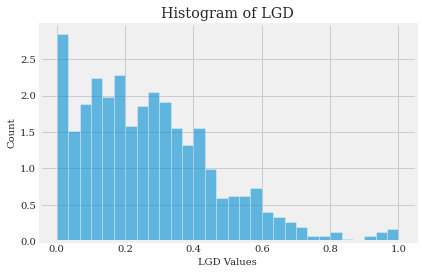

In [188]:
plt.hist(y, bins=30, density=True, alpha = 0.6, linewidth=0.5, edgecolor='white')
plt.title('Histogram of LGD')
plt.xlabel('LGD Values', {'fontsize':'medium'})
plt.ylabel('Count', {'fontsize':'medium'})
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/artworks/lgd_dist.png')

### Gradient Boosting Regressor
The regressor uses RMSE as a loss function. This is the baseline model set to test the performance of the methods in question. The gridsearch of the hyperparameters has not been performed yet. 

The date-time variables have been dropped for now, yet they are to be considered in the future.

In [214]:
#Quick model
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'Non_MI_Recoveries'], axis=1)
y = data['LGD']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0)
# categorical features of the model
cat_features = ['loan_purpose', 'prop_type', 'st', 'prod_type', 'ppmt_pnlty', 'channel', 'occpy_sts', 'occpy_sts', 'flag_fthb',
               'CD_Zero_BAL']
# Creating Pool
train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)

#delq_string should be tranformed to list, month_string should be transformed to list of dates 
model = CatBoostRegressor(iterations=20000,
                          learning_rate=0.02,
                          eval_metric='R2',
                          logging_level='Silent',
#                           task_type = 'GPU',
                          depth=5)
# Fit model
model.fit(train_dataset, plot=True)
# Get predictions
preds = model.predict(test_dataset)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [195]:
from catboost import cv
params = {"iterations": 10000,
          "depth": 5,
          'eval_metric':'R2',
          'learning_rate':0.02,
          "loss_function": "RMSE",
          "verbose": False}

scores = cv(train_dataset,
            params,
            fold_count=5, 
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Model with GridSearch 

In contrast to grid search, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is specified in the n_iter parameter.

In [204]:
grid = {'learning_rate': [0.01, 0.02, 0.1, 0.2],
        'depth': [4, 6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

hyper_model = CatBoostRegressor()
randomized_search_result = hyper_model.randomized_search(grid,
                                                   X=train_dataset,
#                                                    y=y_train1,
                                                   plot=True)

# Fit model
hyper_model.fit(train_dataset, plot=True)
# Get predictions
preds = hyper_model.predict(test_dataset)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1374587638
bestIteration = 990

0:	loss: 0.1374588	best: 0.1374588 (0)	total: 2.74s	remaining: 24.7s

bestTest = 0.1361017354
bestIteration = 101

1:	loss: 0.1361017	best: 0.1361017 (1)	total: 7.54s	remaining: 30.2s

bestTest = 0.1369207339
bestIteration = 462

2:	loss: 0.1369207	best: 0.1361017 (1)	total: 12.3s	remaining: 28.7s

bestTest = 0.1391434142
bestIteration = 999

3:	loss: 0.1391434	best: 0.1361017 (1)	total: 17.1s	remaining: 25.6s

bestTest = 0.1492200702
bestIteration = 969

4:	loss: 0.1492201	best: 0.1361017 (1)	total: 1m 52s	remaining: 1m 52s

bestTest = 0.1531210557
bestIteration = 87

5:	loss: 0.1531211	best: 0.1361017 (1)	total: 3m 27s	remaining: 2m 18s

bestTest = 0.1493236199
bestIteration = 391

6:	loss: 0.1493236	best: 0.1361017 (1)	total: 5m 4s	remaining: 2m 10s

bestTest = 0.1515281498
bestIteration = 999

7:	loss: 0.1515281	best: 0.1361017 (1)	total: 6m 21s	remaining: 1m 35s

bestTest = 0.1482043002
bestIteration = 243

8:	loss: 0.1482043	best: 0.1

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1875978	total: 8.23ms	remaining: 8.22s
1:	learn: 0.1770999	total: 12.7ms	remaining: 6.36s
2:	learn: 0.1695004	total: 18.9ms	remaining: 6.28s
3:	learn: 0.1638289	total: 25.5ms	remaining: 6.35s
4:	learn: 0.1586063	total: 32.4ms	remaining: 6.45s
5:	learn: 0.1536870	total: 38.4ms	remaining: 6.35s
6:	learn: 0.1506381	total: 44.6ms	remaining: 6.33s
7:	learn: 0.1482936	total: 49.5ms	remaining: 6.14s
8:	learn: 0.1455410	total: 55.2ms	remaining: 6.08s
9:	learn: 0.1431256	total: 62ms	remaining: 6.14s
10:	learn: 0.1402733	total: 68.6ms	remaining: 6.17s
11:	learn: 0.1395496	total: 72.8ms	remaining: 5.99s
12:	learn: 0.1369293	total: 77.6ms	remaining: 5.89s
13:	learn: 0.1340717	total: 83.1ms	remaining: 5.85s
14:	learn: 0.1315798	total: 86.7ms	remaining: 5.69s
15:	learn: 0.1309857	total: 92.1ms	remaining: 5.66s
16:	learn: 0.1295924	total: 95.9ms	remaining: 5.54s
17:	learn: 0.1265380	total: 101ms	remaining: 5.5s
18:	learn: 0.1247767	total: 106ms	remaining: 5.46s
19:	learn: 0.1237656	total:

167:	learn: 0.0329522	total: 783ms	remaining: 3.88s
168:	learn: 0.0328553	total: 788ms	remaining: 3.87s
169:	learn: 0.0325078	total: 792ms	remaining: 3.87s
170:	learn: 0.0323680	total: 797ms	remaining: 3.86s
171:	learn: 0.0320150	total: 802ms	remaining: 3.86s
172:	learn: 0.0318130	total: 806ms	remaining: 3.85s
173:	learn: 0.0315805	total: 811ms	remaining: 3.85s
174:	learn: 0.0312500	total: 816ms	remaining: 3.85s
175:	learn: 0.0310659	total: 821ms	remaining: 3.84s
176:	learn: 0.0308739	total: 827ms	remaining: 3.84s
177:	learn: 0.0303141	total: 830ms	remaining: 3.83s
178:	learn: 0.0302726	total: 835ms	remaining: 3.83s
179:	learn: 0.0300954	total: 840ms	remaining: 3.83s
180:	learn: 0.0298744	total: 844ms	remaining: 3.82s
181:	learn: 0.0294804	total: 849ms	remaining: 3.81s
182:	learn: 0.0293665	total: 853ms	remaining: 3.81s
183:	learn: 0.0292814	total: 858ms	remaining: 3.8s
184:	learn: 0.0289383	total: 862ms	remaining: 3.8s
185:	learn: 0.0287009	total: 867ms	remaining: 3.79s
186:	learn: 0.

332:	learn: 0.0124666	total: 1.56s	remaining: 3.12s
333:	learn: 0.0124288	total: 1.56s	remaining: 3.12s
334:	learn: 0.0124030	total: 1.57s	remaining: 3.11s
335:	learn: 0.0123580	total: 1.57s	remaining: 3.11s
336:	learn: 0.0123139	total: 1.58s	remaining: 3.1s
337:	learn: 0.0121984	total: 1.58s	remaining: 3.1s
338:	learn: 0.0121755	total: 1.59s	remaining: 3.1s
339:	learn: 0.0121293	total: 1.59s	remaining: 3.09s
340:	learn: 0.0119713	total: 1.6s	remaining: 3.08s
341:	learn: 0.0119363	total: 1.6s	remaining: 3.08s
342:	learn: 0.0118028	total: 1.6s	remaining: 3.07s
343:	learn: 0.0117380	total: 1.61s	remaining: 3.07s
344:	learn: 0.0116828	total: 1.61s	remaining: 3.06s
345:	learn: 0.0116708	total: 1.62s	remaining: 3.06s
346:	learn: 0.0116014	total: 1.62s	remaining: 3.05s
347:	learn: 0.0115324	total: 1.63s	remaining: 3.05s
348:	learn: 0.0114694	total: 1.63s	remaining: 3.04s
349:	learn: 0.0113778	total: 1.64s	remaining: 3.04s
350:	learn: 0.0113420	total: 1.64s	remaining: 3.03s
351:	learn: 0.0112

531:	learn: 0.0049742	total: 2.54s	remaining: 2.23s
532:	learn: 0.0049336	total: 2.54s	remaining: 2.23s
533:	learn: 0.0049221	total: 2.55s	remaining: 2.22s
534:	learn: 0.0049055	total: 2.55s	remaining: 2.22s
535:	learn: 0.0049035	total: 2.56s	remaining: 2.21s
536:	learn: 0.0048712	total: 2.56s	remaining: 2.21s
537:	learn: 0.0048610	total: 2.57s	remaining: 2.2s
538:	learn: 0.0048551	total: 2.57s	remaining: 2.2s
539:	learn: 0.0048336	total: 2.58s	remaining: 2.19s
540:	learn: 0.0048312	total: 2.58s	remaining: 2.19s
541:	learn: 0.0048139	total: 2.58s	remaining: 2.18s
542:	learn: 0.0047989	total: 2.59s	remaining: 2.18s
543:	learn: 0.0047817	total: 2.59s	remaining: 2.17s
544:	learn: 0.0047240	total: 2.6s	remaining: 2.17s
545:	learn: 0.0047098	total: 2.6s	remaining: 2.16s
546:	learn: 0.0046998	total: 2.61s	remaining: 2.16s
547:	learn: 0.0046982	total: 2.61s	remaining: 2.15s
548:	learn: 0.0046488	total: 2.62s	remaining: 2.15s
549:	learn: 0.0046310	total: 2.62s	remaining: 2.14s
550:	learn: 0.00

692:	learn: 0.0026292	total: 3.32s	remaining: 1.47s
693:	learn: 0.0026229	total: 3.32s	remaining: 1.46s
694:	learn: 0.0026153	total: 3.33s	remaining: 1.46s
695:	learn: 0.0026111	total: 3.33s	remaining: 1.46s
696:	learn: 0.0025929	total: 3.34s	remaining: 1.45s
697:	learn: 0.0025827	total: 3.34s	remaining: 1.45s
698:	learn: 0.0025785	total: 3.35s	remaining: 1.44s
699:	learn: 0.0025648	total: 3.35s	remaining: 1.44s
700:	learn: 0.0025573	total: 3.36s	remaining: 1.43s
701:	learn: 0.0025259	total: 3.36s	remaining: 1.43s
702:	learn: 0.0025128	total: 3.37s	remaining: 1.42s
703:	learn: 0.0025035	total: 3.37s	remaining: 1.42s
704:	learn: 0.0024972	total: 3.38s	remaining: 1.41s
705:	learn: 0.0024887	total: 3.38s	remaining: 1.41s
706:	learn: 0.0024863	total: 3.39s	remaining: 1.4s
707:	learn: 0.0024732	total: 3.39s	remaining: 1.4s
708:	learn: 0.0024659	total: 3.4s	remaining: 1.4s
709:	learn: 0.0024502	total: 3.4s	remaining: 1.39s
710:	learn: 0.0024493	total: 3.41s	remaining: 1.39s
711:	learn: 0.002

870:	learn: 0.0014150	total: 4.3s	remaining: 637ms
871:	learn: 0.0014135	total: 4.31s	remaining: 632ms
872:	learn: 0.0014109	total: 4.31s	remaining: 627ms
873:	learn: 0.0014089	total: 4.32s	remaining: 622ms
874:	learn: 0.0014020	total: 4.32s	remaining: 618ms
875:	learn: 0.0013987	total: 4.33s	remaining: 613ms
876:	learn: 0.0013947	total: 4.34s	remaining: 608ms
877:	learn: 0.0013899	total: 4.34s	remaining: 604ms
878:	learn: 0.0013861	total: 4.35s	remaining: 599ms
879:	learn: 0.0013845	total: 4.36s	remaining: 594ms
880:	learn: 0.0013676	total: 4.36s	remaining: 589ms
881:	learn: 0.0013594	total: 4.37s	remaining: 584ms
882:	learn: 0.0013551	total: 4.37s	remaining: 580ms
883:	learn: 0.0013484	total: 4.38s	remaining: 575ms
884:	learn: 0.0013454	total: 4.38s	remaining: 570ms
885:	learn: 0.0013397	total: 4.39s	remaining: 565ms
886:	learn: 0.0013354	total: 4.4s	remaining: 560ms
887:	learn: 0.0013303	total: 4.4s	remaining: 555ms
888:	learn: 0.0013204	total: 4.41s	remaining: 550ms
889:	learn: 0.0

In [207]:
print(hyper_model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'l2_leaf_reg': 1, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Unifor

### Reporting results: metrics

In [84]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [92]:
# adjusted R^2 function

# def adj_r2(y_test1, preds):
#     return 1-(1-r2_score(y_test1, preds))*((len(X_test1)-1)/(len(X_test1)-len(X_test1.columns)-1))

def adj_r2(X_actual_test, y_actual_test, predictions):
    return 1-(1-r2_score(y_actual_test, predictions))*((len(X_actual_test)-1)/(len(X_actual_test)-len(X_actual_test.columns)-1))

Adjusted R^2 0.310894803424985
R^2 of the model 0.48983372187264085
RMSE of the model 0.1417378993054332


In [215]:
#Training  results without any hyper search with RMSE as the loss function
#Huber loss with delta = 0.1, learning rate = 0.02, iterations = 20000, Cosine score function
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, model.predict(train_dataset)))

Training: Adjusted R^2 0.9889980148427411
Training: R^2 of the model 0.9896960718320292
Training: RMSE of the model 0.020080255801300604
Training: MSE of the model 0.0004032166730456666


In [216]:
#Testing results without any hyper search with RMSE as the loss function

rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.31291517035442906
Testing: R^2 of the model 0.487533414352751
Testing: RMSE of the model 0.13840071387483957
Testing: MSE of the model 0.019154757601065213


In [205]:
# After grid search
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, hyper_model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, hyper_model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, hyper_model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, hyper_model.predict(train_dataset)))

Training: Adjusted R^2 0.984721068286383
Training: R^2 of the model 0.9857115645491967
Training: RMSE of the model 0.023646135197671406
Training: MSE of the model 0.0005591397097865546


In [206]:
rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.23422277878326048
Testing: R^2 of the model 0.43307100749699945
Testing: RMSE of the model 0.1455693313513915
Testing: MSE of the model 0.021190430230091213


#### Model Benchmarking with OLS

In [144]:
import statsmodels.api as sm
benchmarking_X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'flag_fthb', 'channel', 'ppmt_pnlty', 'prod_type', 'st', 'prop_type', 'loan_purpose', 'occpy_sts'], axis=1)
benchmarking_y = data['LGD']
X_train1, X_test1, y_train1, y_test1 = train_test_split(benchmarking_X, benchmarking_y, test_size=0.2, random_state=0)


                            OLS Regression Results                            
Dep. Variable:                    LGD   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     30.99
Date:                Fri, 23 Jul 2021   Prob (F-statistic):          3.40e-121
Time:                        11:56:04   Log-Likelihood:                 530.91
No. Observations:                 908   AIC:                            -995.8
Df Residuals:                     875   BIC:                            -837.0
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
delq_sts                  0.00

In [154]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train1, y_train1)
y_predicted = lm.predict(X_test1)
y_train_predict = lm.predict(X_train1)


print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, y_predicted))
print('Testing: R^2 of the model', r2_score(y_test1, y_predicted))
print('Testing: RMSE of the model', (np.sqrt(mean_squared_error(y_test1, y_predicted))))
print('Testing: MSE of the model', mean_squared_error(y_test1, y_predicted))

print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, y_train_predict))
print('Training: R^2 of the model', r2_score(y_train1, y_train_predict))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, y_train_predict))))
print('Training: MSE of the model', mean_squared_error(y_train1, y_train_predict))

Testing: Adjusted R^2 0.3649386627986154
Testing: R^2 of the model 0.5017750835215657
Testing: RMSE of the model 0.1364640559317346
Testing: MSE of the model 0.018622438561339594
Training: Adjusted R^2 0.5052161355607623
Training: R^2 of the model 0.5318320951650799
Training: RMSE of the model 0.13535323761811724
Training: MSE of the model 0.018320498933706506


#### Results of the model

The results of the model suggests that the model explains most of the variance in the data, judging by the adjusted R^2, R^2 and RMSE. 

### Feature Importance

This section considers two distinct methods in calculating feature importance. 

* **Shap Values**: A vector $\nu$  with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).
* **PredictionValuesChange**: For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
* **LossFunctionChange**: The individual importance values for each of the input features (the default feature importances calculation method for ranking metrics). This type of feature importance can be used for any model, but is particularly useful for ranking models, where other feature importance types might give misleading results. For each feature the value represents the difference between the loss value of the model with this feature and without it. *Since it is computationally expensive to retrain the model without one of the features, this model is built approximately using the original model with this feature removed from all the trees in the ensemble.*

Last two are calculated for training and testing sets. Both are of great importance since: 
1. The use of training set allows to assess how much the model relies on each feature for making predictions
2. The use of testing set allows to evaluate how much the feature contributes to the performance of the model on unseen data 

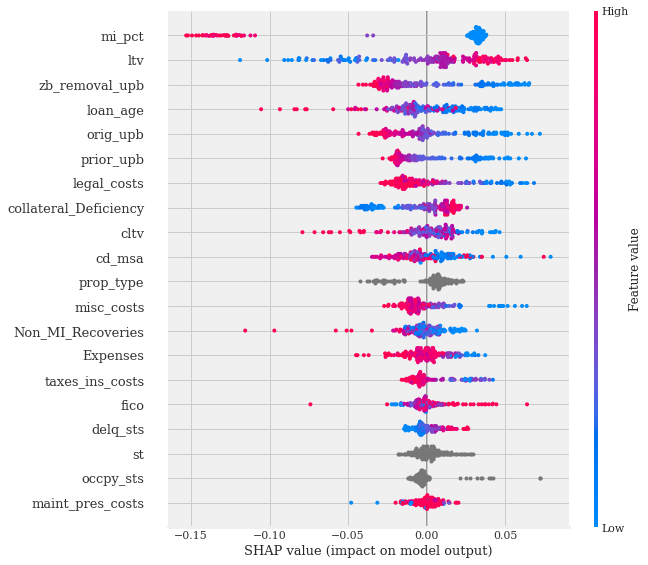

In [211]:
# Starting with Shap Values. Calculating each single contribution
import shap
shap_values = model.get_feature_importance(test_dataset, type="ShapValues")

shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_test1) 

In [165]:
# matplotlib settings
import matplotlib as mpl
plt.style.use(['seaborn-bright'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})

%matplotlib inline

In [241]:

from sklearn import metrics


def get_feature_imp_plot(method):
    
#     if method == "Permutation":
#         fi =  permutation_importances(model, X_test1, y_test1, log_loss)
    
#     elif method == "Baseline":
#         fi = baseline_importance(model, X_train1, y_train1, X_test1, y_test1, log_loss)
    
#     elif method == "ShapeValues":
#         shap_values = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
#                                                                      type="ShapValues")
#         shap_values = shap_values[:,:-1]
#         shap.summary_plot(shap_values, X_test) 
        
#     else:
    fi = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', edgecolor='white', alpha = 0.6)
        ax.set_title("Testing set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.gcf().subplots_adjust(bottom=0.3)
        plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/artworks/Testing set-{}'.format(method))
        plt.show()

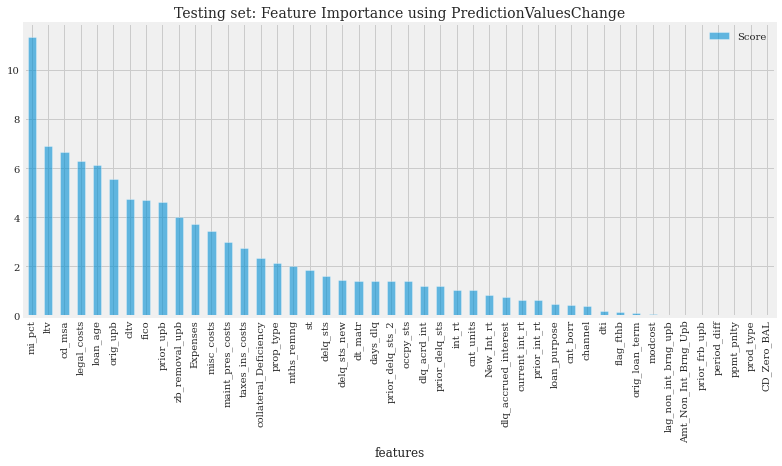

In [242]:
get_feature_imp_plot(method="PredictionValuesChange")
# plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/artworks/testing-feature-predict-value-change.png')

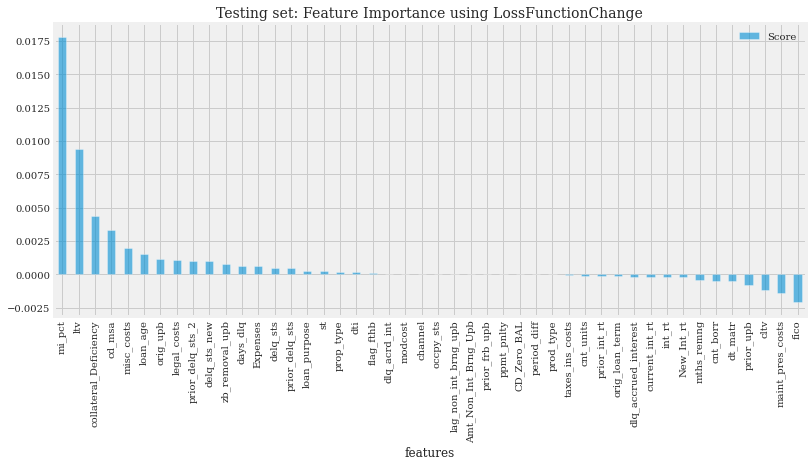

In [243]:
get_feature_imp_plot(method="LossFunctionChange")

In [246]:
def get_feature_imp_plot_train(method):
    

    fi = model.get_feature_importance(Pool(X_train1, label=y_train1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_train1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar',  edgecolor='white', alpha = 0.6)
        ax.set_title("Training set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.gcf().subplots_adjust(bottom=0.3)
        plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/artworks/Training_set-{}'.format(method))
        plt.show()

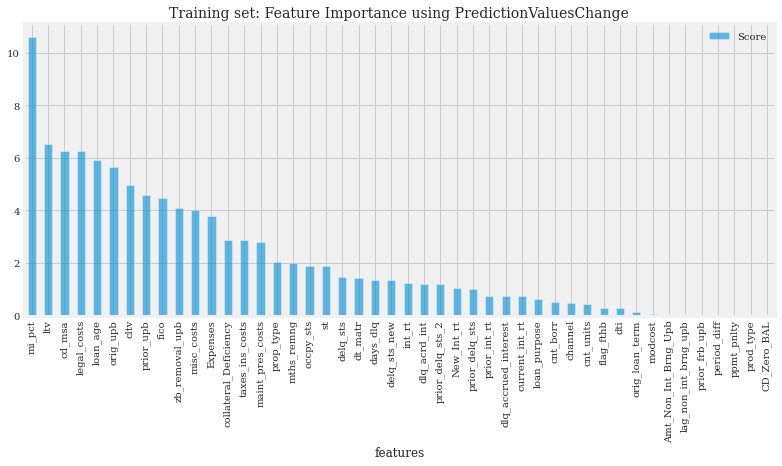

In [247]:
get_feature_imp_plot_train(method="PredictionValuesChange")

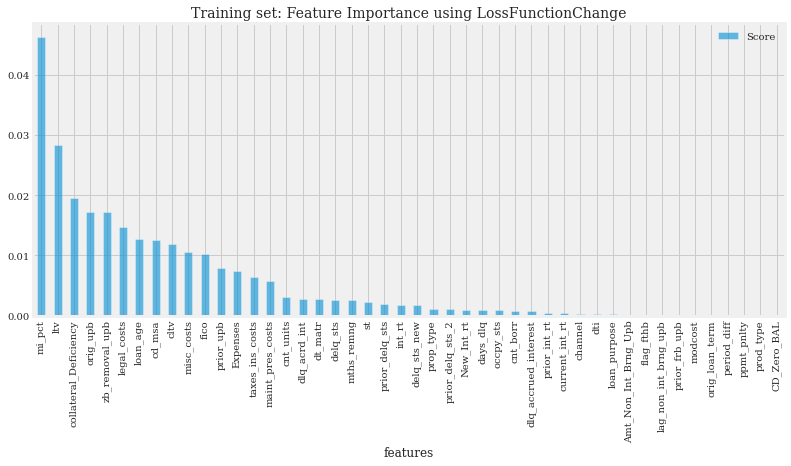

In [248]:
get_feature_imp_plot_train(method="LossFunctionChange")

In [105]:
# Check the error distribution and then minimise the Huber function

# model_huber = CatBoostRegressor(iterations=1000,
#                           learning_rate=1,
#                           logging_level='Silent',
#                           loss_function='Huber',
#                           depth=2)


# # Fit model
# model_huber.fit(train_dataset, plot=True)
# # Get predictions
# preds_huber = model.predict(test_dataset)
clear_output()

In [182]:
model